## Acquiring the data

In [114]:
import numpy as np
import pandas as pd
import glob

#Adding relative path name to data variable. Dataset suffix is data when it's available

data = [i for i in glob.glob('../data/data*.csv')]
    
#Rows skipped to avoid additional cleaning, dates parsed and date used as the index

MM = pd.read_csv(data[0], skiprows=[1, 483], header= 0, 
                 na_values=0, parse_dates=['Payouts Payout Currency'], 
                 index_col='Payouts Payout Currency').rename_axis(None)

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
#This function sets the beginning of the time series based on first 3 consecutives weeks without FX MM
def series_begins(x):
    nan_index = x.index[x.isnull()]
    for i in range(0,len(nan_index)):
        upper = i + 2
        difference = nan_index[i] - nan_index[(upper)]
        if difference.days == 14:
            return nan_index[i]


In [ ]:
MM['KRW'].loc[series_ends(MM['KRW']):].index[MM['KRW'].loc[series_ends(MM['KRW']):].isnull()]

In [ ]:
#This function sets the end of the time series based on last 2 consecutives weeks with FX MM
def series_ends(x):
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            return notnan_index[i]

In [ ]:
def series_ends_begins(x):
    ends_begins = []
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            ends_begins.append(notnan_index[i])
            nan_index = x.loc[ends_begins[0]:].index[x.loc[ends_begins[0]:].isnull()]
            for i in range(0,len(nan_index)):
                upper = i + 2
                difference = nan_index[i] - nan_index[(upper)]
                if difference.days == 14:
                    ends_begins.append(nan_index[i])
                    return ends_begins
                
                
type(series_ends_begins(MM['GBP']))

In [3]:
"""
This function lists the end, based on last 2 consecutives weeks with FX MM
and the start, based on on first 3 consecutives weeks without FX MM, of the timeseries.
"""


def series_end_start(x):
    end_start = [0,0]
    notnan_index = x.index[x.notna()]
    for i in range(0,len(notnan_index)):
        notnan_upper = i + 1
        notnan_difference = notnan_index[i] - notnan_index[(notnan_upper)]
        if notnan_difference.days == 7:
            end_start[0] = notnan_index[i]
            nan_index = x.loc[end_start[0]:].index[x.loc[end_start[0]:].isnull()]
            for i in range(0,len(nan_index)):
                upper = i + 2
                difference = nan_index[i] - nan_index[(upper)]
                if difference.days == 14:
                    end_start[1] = nan_index[i]
                    return end_start

In [ ]:
series_end_start(MM['PEN'])

In [ ]:
series_ends_begins(MM['KRW'])

In [ ]:
series = [0,0]
series[1] = 1
series

In [ ]:
#Beginning dates are passed on a dictionary per feature in the data set

dict_series_begings = {i:series_begins(MM[i]) for i in MM.columns}

In [73]:
#Series end and start dates are passed on to dictionary

dict_series_end_start = {i:series_end_start(MM[i]) for i in MM.columns}

In [74]:
dict_series_end_start

{'AED': [Timestamp('2020-03-23 00:00:00'), Timestamp('2015-11-09 00:00:00')],
 'AUD': [Timestamp('2020-03-23 00:00:00'), Timestamp('2013-12-23 00:00:00')],
 'CAD': [Timestamp('2020-03-23 00:00:00'), Timestamp('2013-12-23 00:00:00')],
 'CHF': [Timestamp('2020-03-23 00:00:00'), Timestamp('2015-10-19 00:00:00')],
 'CNY': [Timestamp('2020-03-23 00:00:00'), Timestamp('2017-07-10 00:00:00')],
 'CZK': [Timestamp('2020-03-16 00:00:00'), Timestamp('2020-02-17 00:00:00')],
 'EUR': [Timestamp('2020-03-23 00:00:00'), Timestamp('2013-12-23 00:00:00')],
 'GBP': [Timestamp('2020-03-23 00:00:00'), Timestamp('2013-12-30 00:00:00')],
 'HKD': [Timestamp('2020-03-23 00:00:00'), Timestamp('2015-03-09 00:00:00')],
 'JPY': [Timestamp('2020-03-23 00:00:00'), Timestamp('2015-12-14 00:00:00')],
 'KRW': [Timestamp('2020-02-10 00:00:00'), Timestamp('2019-12-30 00:00:00')],
 'MYR': [Timestamp('2020-03-23 00:00:00'), Timestamp('2017-10-23 00:00:00')],
 'NOK': [Timestamp('2020-03-23 00:00:00'), Timestamp('2018-07-23

In [ ]:
MM.loc[dict_series_end_start['USD'][0]:dict_series_end_start['USD'][1],'USD'].iloc[:-1]

In [5]:
#The function creates a data frame bounded by the end and start of the series

def get_df(x):
    try:
        series = MM.loc[dict_series_end_start[x][0]:dict_series_end_start[x][1],x].iloc[:-1].fillna(0)
        df_output = series.reset_index().rename({'index':'ds', x:'y'}, axis=1)
        return df_output
    except:
        return print(f"There isn't enough historic data to predict {x} volumes or {x} is not a valid market.")

In [ ]:
get_df('GUA')

In [8]:
from matplotlib import pyplot as plt
from fbprophet import Prophet

In [121]:
def create_forecast(market, period, frequency):
    X = get_df(market)
    m = Prophet(seasonality_mode='multiplicative')
    
    m.fit(X)
    future = m.make_future_dataframe(periods=period, freq=frequency)
    future.tail()
    forecast = m.predict(future)
    m.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [36]:
?Prophet.make_future_dataframe

Signature:
Prophet.make_future_dataframe(
    self,
    periods,
    freq='D',
    include_history=True,
)
Docstring:
Simulate the trend using the extrapolated generative model.

Parameters
----------
periods: Int number of periods to forecast forward.
freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
include_history: Boolean to include the historical dates in the data
    frame for predictions.

Returns
-------
pd.Dataframe that extends forward from the end of self.history for the
requested number of periods.
File:      ~/miniconda3/envs/final-project/lib/python3.7/site-packages/fbprophet/forecaster.py
Type:      function


In [25]:
MM['USD']

2020-03-16    4.192343e+06
2020-03-09    1.234588e+07
2020-03-02    1.310827e+07
2020-02-24    1.597301e+07
2020-02-17    1.453787e+07
Name: USD, dtype: float64

In [97]:
#Cross Validation

from fbprophet.diagnostics import cross_validation

cv_results = cross_validation(model=m, initial=pd.to_timedelta(208, unit="W"), 
                              period=pd.to_timedelta(13, unit="W"), 
                              horizon=pd.to_timedelta(13, unit="W"))

cv_results.head()

INFO:fbprophet:Making 8 forecasts with cutoffs between 2018-03-26 00:00:00 and 2019-12-23 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-04-02,2.263522e+06,2.013803e+06,2.514157e+06,2.684786e+06,2018-03-26
1,2018-04-09,2.499000e+06,2.244418e+06,2.753691e+06,3.053409e+06,2018-03-26
2,2018-04-16,2.830999e+06,2.571965e+06,3.080366e+06,3.187652e+06,2018-03-26
3,2018-04-23,3.052357e+06,2.798999e+06,3.304552e+06,3.687497e+06,2018-03-26
4,2018-04-30,3.065925e+06,2.803985e+06,3.321541e+06,3.889862e+06,2018-03-26


In [111]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [115]:
mean_absolute_percentage_error(cv_results.y, cv_results.yhat)

16.698271993497123

In [63]:
?plot_cross_validation_metric

Signature:
plot_cross_validation_metric(
    df_cv,
    metric,
    rolling_window=0.1,
    ax=None,
    figsize=(10, 6),
)
Docstring:
Plot a performance metric vs. forecast horizon from cross validation.

Cross validation produces a collection of out-of-sample model predictions
that can be compared to actual values, at a range of different horizons
(distance from the cutoff). This computes a specified performance metric
for each prediction, and aggregated over a rolling window with horizon.

This uses fbprophet.diagnostics.performance_metrics to compute the metrics.
Valid values of metric are 'mse', 'rmse', 'mae', 'mape', and 'coverage'.

rolling_window is the proportion of data included in the rolling window of
aggregation. The default value of 0.1 means 10% of data are included in the
aggregation for computing the metric.

As a concrete example, if metric='mse', then this plot will show the
squared error for each cross validation prediction, along with the MSE
averaged over rolling 

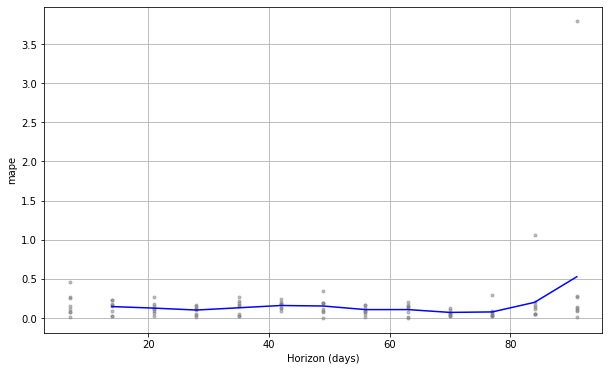

In [102]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_p = performance_metrics(cv_results)

fig = plot_cross_validation_metric(cv_results, metric='mape')

In [101]:
?performance_metrics

Signature: performance_metrics(df, metrics=None, rolling_window=0.1)
Docstring:
Compute performance metrics from cross-validation results.

Computes a suite of performance metrics on the output of cross-validation.
By default the following metrics are included:
'mse': mean squared error
'rmse': root mean squared error
'mae': mean absolute error
'mape': mean percent error
'coverage': coverage of the upper and lower intervals

A subset of these can be specified by passing a list of names as the
`metrics` argument.

Metrics are calculated over a rolling window of cross validation
predictions, after sorting by horizon. Averaging is first done within each
value of horizon, and then across horizons as needed to reach the window
size. The size of that window (number of simulated forecast points) is
determined by the rolling_window argument, which specifies a proportion of
simulated forecast points to include in each window. rolling_window=0 will
compute it separately for each horizon. The def

In [100]:
from fbprophet.diagnostics import performance_metrics


df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,14 days,8.430306e+11,9.181670e+05,7.360216e+05,0.146136,0.135040,0.350
1,21 days,5.256873e+11,7.250430e+05,5.971674e+05,0.126409,0.130321,0.375
2,28 days,3.093849e+11,5.562238e+05,4.709454e+05,0.101722,0.111606,0.375
3,35 days,3.347328e+11,5.785610e+05,5.058599e+05,0.130596,0.134224,0.375
4,42 days,7.219473e+11,8.496748e+05,7.232392e+05,0.159699,0.177163,0.175
5,49 days,1.220274e+12,1.104660e+06,7.950127e+05,0.153284,0.180731,0.225
6,56 days,5.549852e+11,7.449733e+05,5.395478e+05,0.107417,0.105548,0.450
7,63 days,4.208086e+11,6.486976e+05,5.403038e+05,0.107628,0.144551,0.300
8,70 days,2.397949e+11,4.896885e+05,4.109873e+05,0.071477,0.065487,0.550
9,77 days,5.019103e+11,7.084563e+05,5.253878e+05,0.077816,0.053782,0.525


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


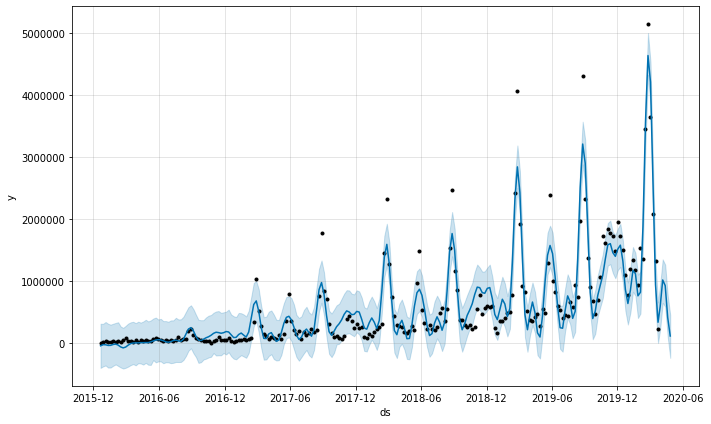

In [122]:
create_forecast('JPY', 5, 'W')

In [ ]:
for i in ['AUD', 'CAD', 'EUR', 'GBP', 'JPY', 'USD']:
    create_forecast(i, 10, 'W')

#create_forecast('CAD', 10, 'W')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


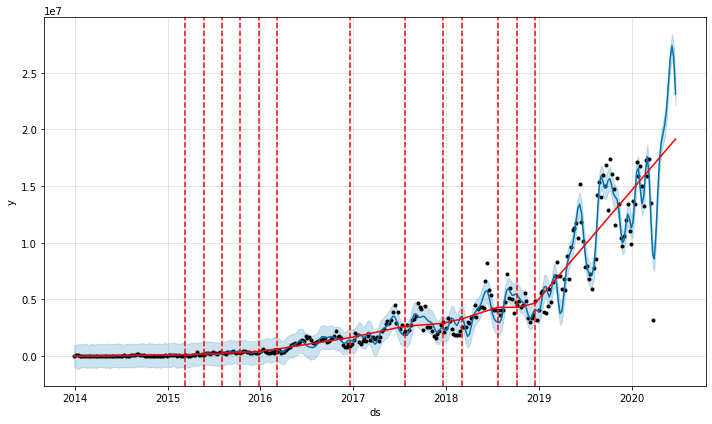

In [117]:
from fbprophet.plot import add_changepoints_to_plot

baseline = get_df('CAD')
baseline['floor'] = 0
m = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.5)


m.fit(baseline)
futures = m.make_future_dataframe(periods=13, freq='W')
forecast = m.predict(futures)
#print(futures.tail(13))
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [94]:
print(m.changepoints)

10    2014-03-17
21    2014-06-02
31    2014-08-11
41    2014-10-20
52    2015-01-05
62    2015-03-16
73    2015-06-01
83    2015-08-10
93    2015-10-19
104   2016-01-04
114   2016-03-14
124   2016-05-23
135   2016-08-08
145   2016-10-17
155   2016-12-26
166   2017-03-13
176   2017-05-22
186   2017-07-31
197   2017-10-16
207   2017-12-25
218   2018-03-12
228   2018-05-21
238   2018-07-30
249   2018-10-15
259   2018-12-24
Name: ds, dtype: datetime64[ns]


In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()


## Cleaning Data